In [1]:
import numpy as np
import pandas as pd

from vulkan_public.beam.local.runner import PolicyRunner
from vulkan_public.core.policy import Policy
from vulkan_public.schemas import DataSourceSpec
from vulkan_public.spec.dependency import INPUT_NODE

In [2]:
DATA_SOURCE_A_ID = "api:data-source-a:v1"
MODEL_A_ID = "api:model-a:v1"
DATA_SOURCE_B_ID = "api:data-source-b:v23"
MODEL_B_ID = "api:model-b-serasa-teste-etc-etc:v34"

## Preparations

We'll create a Parquet file with our input data, and a second file to act as a "Data Source".

Data Sources bring external data into your workflow. 
This can be done by consulting a bureau, or by having some test data, like in our case here.

In [3]:
data_source_a_test_schema = {
    "name": DATA_SOURCE_A_ID,
    "keys": ["tax_id"],
    "source": {
        "path": "data_source_a.parquet",
    },
}

model_a_test_schema = {
    "name": MODEL_A_ID,
    "keys": ["tax_id"],
    "source": {
        "path": "data_source_model_a.parquet",
    },
}

data_sources = [
    DataSourceSpec.model_validate(data_source_a_test_schema),
    DataSourceSpec.model_validate(model_a_test_schema),
]

In [4]:
df = pd.read_csv("../data/simple_bkt_lg.csv")
df["month"] = df["month"].astype(str)
df["tax_id"] = df["tax_id"].astype(str)

df.to_parquet("input.parquet")

data_source_a = df[["tax_id"]]
data_source_a["valid"] = np.random.choice(
    [True, False], size=data_source_a.shape[0], p=[0.5, 0.5]
)
data_source_a.to_parquet("data_source_a.parquet")

model_a = df[["tax_id", "score"]]
model_a.to_parquet("data_source_model_a.parquet")


data_source_b = df[["tax_id"]]
data_source_b["valid"] = np.random.choice(
    [True, False], size=data_source_b.shape[0], p=[0.8, 0.2]
)
data_source_b.to_parquet("data_source_b.parquet")

model_b = df[["tax_id", "score"]]
model_b["score"] = 1000 - model_b["score"]
model_b.to_parquet("data_source_model_b.parquet")

/tmp/ipykernel_16326/3174337014.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_source_a["valid"] = np.random.choice(
/tmp/ipykernel_16326/3174337014.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_source_b["valid"] = np.random.choice(
/tmp/ipykernel_16326/3174337014.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

## Define the Policy

This is all the code used to define the policy. \
In fact, in `docs/examples/policies/local/test_policy/policy.py` 
we use the exact same code to create our "packaged" version, 
which we'll use later for remote execution.

There are a few key parts here:
- `DataInputNode`: These nodes are used to bring data into your decision flows. Here, we'll use a local file, but this can later be replaced with an API or database without having to change the flow
- `branch_condition` and `BranchNode`: "Branches" are how we make decisions in our policies. At a branch, you can have any number of possible outputs. In our case here, we write a function that returns "approved" if the score is greater than a cutoff.
- `TerminateNode`: Terminate nodes are how we represent the final step in a policy, or the final decision. The `return_status` value is the final decision made. Here, we either approve or deny someone. We'll later see how this can be used to pass information to other systems.

In [5]:
from enum import Enum

from vulkan_public.spec.dependency import INPUT_NODE, Dependency
from vulkan_public.spec.nodes import (
    BranchNode,
    DataInputNode,
    TerminateNode,
    TransformNode,
)
from vulkan_public.spec.policy import PolicyDefinition

CONTINUE = "CONTINUE"


class Status(Enum):
    DENY_NO_DATA_A = "DENY_NO_DATA_A"
    DENY_SCORE_A = "DENY_SCORE_A"
    APPROVE = "APPROVE"


# START: Data Source + Model A
data_source_a = DataInputNode(
    name="data_source_a",
    description="My first Data Source",
    source=DATA_SOURCE_A_ID,
    dependencies={"inputs": Dependency(INPUT_NODE)},
)

check_source_a = BranchNode(
    name="check_source_a",
    func=lambda source_a: CONTINUE
    if source_a["valid"]
    else Status.DENY_NO_DATA_A.value,
    dependencies={"source_a": Dependency(data_source_a.name)},
    outputs=[CONTINUE, Status.DENY_NO_DATA_A.value],
)

deny_no_data_a = TerminateNode(
    name=Status.DENY_NO_DATA_A.value,
    return_status=Status.DENY_NO_DATA_A,
    dependencies={
        "condition": Dependency(check_source_a.name, Status.DENY_NO_DATA_A.value)
    },
)


preprocess_model_a_request = TransformNode(
    name="preprocess_model_a_request",
    description="Data Sources currently need to receive a structure that contains all the keys in the root level",
    func=lambda inputs, source_a, condition: {**inputs, **source_a},
    dependencies={
        "inputs": Dependency(INPUT_NODE),
        "source_a": Dependency(data_source_a.name),
        "condition": Dependency(check_source_a.name, CONTINUE),
    },
)

model_a = DataInputNode(
    name="Model A",
    description="Get score from Model A",
    source=MODEL_A_ID,
    dependencies={"data": Dependency(preprocess_model_a_request.name)},
)


def _decide_model_a(context, response_model_a) -> str:
    if response_model_a is None:
        return Status.DENY_SCORE_A.value

    elif response_model_a["score"] >= context.env.get("THRESHOLD_MODEL_A"):
        return Status.DENY_SCORE_A.value

    return Status.APPROVE.value


decide_model_a = BranchNode(
    name="decide_model_a",
    func=_decide_model_a,
    dependencies={"response_model_a": Dependency(model_a.name)},
    outputs=[Status.APPROVE.value, Status.DENY_SCORE_A.value],
)

deny_score_a = TerminateNode(
    name=Status.DENY_SCORE_A.value,
    return_status=Status.DENY_SCORE_A,
    dependencies={
        "condition": Dependency(decide_model_a.name, Status.DENY_SCORE_A.value)
    },
)
# END Model with Source A

approve = TerminateNode(
    name=Status.APPROVE.value,
    return_status=Status.APPROVE,
    dependencies={"condition": Dependency(decide_model_a.name, Status.APPROVE.value)},
)

demo_policy = PolicyDefinition(
    nodes=[
        data_source_a,
        check_source_a,
        deny_no_data_a,
        preprocess_model_a_request,
        model_a,
        decide_model_a,
        deny_score_a,
        approve,
    ],
    components=[],
    config_variables=["THRESHOLD_MODEL_A"],
    input_schema={"tax_id": str},
)

In [6]:
policy = Policy.from_definition(demo_policy)

## Run the Policy Locally 

The entire policy can be visualized and the run locally.

To do that, we'll just have to do two things:
1. Create a schema, telling Vulkan where to get data for the data sources;
2. Set a value for our score "cutoff": the minimum score to be Approved;

### Visualizing the flow of information

We can visualize our policy locally, at all times. \
This can show us how the clients are being treated and where we're making each decision.

In [7]:
runner = PolicyRunner(policy, staging_path="./output/")

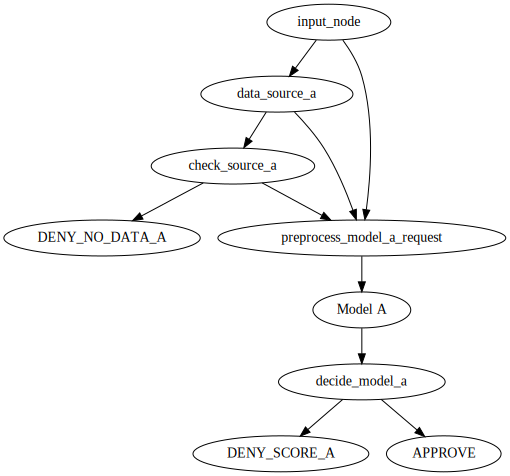

In [8]:
runner.graph()

### Running

Now we're ready to run our policy.

Let's start with a single example:

In [9]:
config_variables = {"THRESHOLD_MODEL_A": 650}

result = runner.run(
    input_data={"tax_id": "1"},
    data_sources=data_sources,
    config_variables=config_variables,
)

print("Here are our results:\n")
result.data

Here are our results:



{'input_node': [{'tax_id': '1'}],
 'result': [{'status': 'DENY_NO_DATA_A'}, {'status': 'DENY_SCORE_A'}]}

### Running for a bunch of data

We can run for 1 example, or for a bunch, just as easily. \
To run for a batch of data, we just need to pass the input data with a file. \
Let's pass in the input file we created at the beginning.

In [10]:
%%time
batch_results = runner.run_batch(
    input_data_path="input.parquet",
    data_sources=data_sources,
    config_variables=config_variables,
)

CPU times: user 3.72 s, sys: 742 ms, total: 4.46 s
Wall time: 4.66 s


In [11]:
batch_results.data

,backfill_id,key,status,input_node
0,1743082522112218,f0369ba55a60b5bc5bc8666a964c395c,DENY_NO_DATA_A,{'tax_id': '0'}
1,1743082522112218,60a146574a1ec5f09a27e1f15ae95ded,DENY_NO_DATA_A,{'tax_id': '1'}
2,1743082522112218,761f36e599f6ca3cfb859271468973f2,DENY_NO_DATA_A,{'tax_id': '2'}
3,1743082522112218,3254c1565be80b4fe68c057671204ff6,DENY_SCORE_A,{'tax_id': '3'}
4,1743082522112218,0e16afcc463ccb97987fd290aa35dc9d,DENY_SCORE_A,{'tax_id': '4'}
...,...,...,...,...
995,1743082522112218,53861153a4b25a166752c788cf1d6e36,APPROVE,{'tax_id': '995'}
996,1743082522112218,7fd9223d882ffd7bdcd47b6a58992371,DENY_NO_DATA_A,{'tax_id': '996'}
997,1743082522112218,b41eaa06a9f79346369d7ebe486df932,DENY_SCORE_A,{'tax_id': '997'}
998,1743082522112218,f4e11cf9a984c8554f09aa7720c6a7b8,DENY_NO_DATA_A,{'tax_id': '998'}


## Ramping it up: Two sources, two models

### Preparing our new data sources

In [12]:
data_source_b_test_schema = {
    "name": DATA_SOURCE_B_ID,
    "keys": ["tax_id"],
    "source": {
        "path": "data_source_b.parquet",
    },
}

model_b_test_schema = {
    "name": MODEL_B_ID,
    "keys": ["tax_id"],
    "source": {
        "path": "data_source_model_b.parquet",
    },
}

data_sources = [
    DataSourceSpec.model_validate(data_source_a_test_schema),
    DataSourceSpec.model_validate(model_a_test_schema),
    DataSourceSpec.model_validate(data_source_b_test_schema),
    DataSourceSpec.model_validate(model_b_test_schema),
]

In [13]:
from enum import Enum

from vulkan_public.spec.dependency import INPUT_NODE, Dependency
from vulkan_public.spec.nodes import (
    BranchNode,
    DataInputNode,
    TerminateNode,
    TransformNode,
)
from vulkan_public.spec.policy import PolicyDefinition

CONTINUE = "CONTINUE"


class Status(Enum):
    DENY_NO_DATA_A = "DENY_NO_DATA_A"
    DENY_SCORE_A = "DENY_SCORE_A"
    DENY_NO_DATA_B = "DENY_NO_DATA_B"
    DENY_SCORE_B = "DENY_SCORE_B"
    APPROVE = "APPROVE"


# START: Data Source + Model A
data_source_a = DataInputNode(
    name="data_source_a",
    description="My first Data Source",
    source=DATA_SOURCE_A_ID,
    dependencies={"inputs": Dependency(INPUT_NODE)},
)


def check_source_a(source_a) -> str:
    if not source_a["valid"]:
        return Status.DENY_NO_DATA_A.value
    return CONTINUE


check_source_a = BranchNode(
    name="check_source_a",
    func=_check_source_a,
    dependencies={"source_a": Dependency(data_source_a.name)},
    outputs=[CONTINUE, Status.DENY_NO_DATA_A.value],
)

deny_no_data_a = TerminateNode(
    name=Status.DENY_NO_DATA_A.value,
    return_status=Status.DENY_NO_DATA_A,
    dependencies={
        "condition": Dependency(check_source_a.name, Status.DENY_NO_DATA_A.value)
    },
)


preprocess_model_a_request = TransformNode(
    name="preprocess_model_a_request",
    description="Data Sources currently need to receive a structure that contains all the keys in the root level",
    func=lambda inputs, source_a, condition: {**inputs, **source_a},
    dependencies={
        "inputs": Dependency(INPUT_NODE),
        "source_a": Dependency(data_source_a.name),
        "condition": Dependency(check_source_a.name, CONTINUE),
    },
)

model_a = DataInputNode(
    name="Model A",
    description="Get score from Model A",
    source=MODEL_A_ID,
    dependencies={"data": Dependency(preprocess_model_a_request.name)},
)


def _decide_model_a(context, response_model_a) -> str:
    if response_model_a is None:
        return Status.DENY_SCORE_A.value

    elif response_model_a["score"] >= context.env.get("THRESHOLD_MODEL_A"):
        return Status.DENY_SCORE_A.value

    return CONTINUE


decide_model_a = BranchNode(
    name="decide_model_a",
    func=_decide_model_a,
    dependencies={"response_model_a": Dependency(model_a.name)},
    outputs=[CONTINUE, Status.DENY_SCORE_A.value],
)


deny_score_a = TerminateNode(
    name=Status.DENY_SCORE_A.value,
    return_status=Status.DENY_SCORE_A,
    dependencies={
        "condition": Dependency(decide_model_a.name, Status.DENY_SCORE_A.value)
    },
)
# END Model with Source A

# Start Data Source and Model B
make_source_b_request = TransformNode(
    name="make_source_b_request",
    func=lambda inputs, condition: inputs,
    dependencies={
        "inputs": Dependency(INPUT_NODE),
        "condition": Dependency(decide_model_a.name, CONTINUE),
    },
)

data_source_b = DataInputNode(
    name="data_source_b",
    description="The Second Data Source!",
    source=DATA_SOURCE_B_ID,
    dependencies={"data": Dependency(make_source_b_request.name)},
)

check_source_b = BranchNode(
    name="check_source_b",
    func=lambda data: CONTINUE if data["valid"] else Status.DENY_NO_DATA_B.value,
    dependencies={"data": Dependency(data_source_b.name)},
    outputs=[CONTINUE, Status.DENY_NO_DATA_B.value],
)

deny_no_data_b = TerminateNode(
    name=Status.DENY_NO_DATA_B.value,
    return_status=Status.DENY_NO_DATA_B,
    dependencies={
        "condition": Dependency(check_source_b.name, Status.DENY_NO_DATA_B.value)
    },
)

preprocess_model_b_request = TransformNode(
    name="preprocess_model_b_request",
    description="Data Sources currently need to receive a structure that contains all the keys in the root level",
    func=lambda inputs, source_a, source_b, condition: {
        **inputs,
        **source_a,
        **source_b,
    },
    dependencies={
        "inputs": Dependency(INPUT_NODE),
        "source_a": Dependency(data_source_a.name),
        "source_b": Dependency(data_source_b.name),
        "condition": Dependency(check_source_b.name, CONTINUE),
    },
)

model_b = DataInputNode(
    name="model_b",
    description="Get score from Model B using two data sources",
    source=MODEL_B_ID,
    dependencies={"data": Dependency(preprocess_model_b_request.name)},
)


def _decide_model_b(context, model_response) -> str:
    if model_response is None:
        return Status.DENY_SCORE_B.value

    elif model_response["score"] >= context.env.get("THRESHOLD_MODEL_B"):
        return Status.DENY_SCORE_B.value

    return Status.APPROVE.value


decide_model_b = BranchNode(
    name="decide_model_b",
    func=_decide_model_b,
    dependencies={"model_response": Dependency(model_b.name)},
    outputs=[Status.APPROVE.value, Status.DENY_SCORE_B.value],
)


deny_score_b = TerminateNode(
    name=Status.DENY_SCORE_B.value,
    return_status=Status.DENY_SCORE_B,
    dependencies={
        "condition": Dependency(decide_model_b.name, Status.DENY_SCORE_B.value)
    },
)
# END Model with Sources A and B

approve = TerminateNode(
    name=Status.APPROVE.value,
    return_status=Status.APPROVE,
    dependencies={"condition": Dependency(decide_model_b.name, Status.APPROVE.value)},
)

demo_policy = PolicyDefinition(
    nodes=[
        data_source_a,
        check_source_a,
        deny_no_data_a,
        preprocess_model_a_request,
        model_a,
        decide_model_a,
        deny_score_a,
        make_source_b_request,
        data_source_b,
        check_source_b,
        deny_no_data_b,
        preprocess_model_b_request,
        model_b,
        decide_model_b,
        deny_score_b,
        approve,
    ],
    components=[],
    config_variables=["THRESHOLD_MODEL_A", "THRESHOLD_MODEL_B"],
    input_schema={"tax_id": str},
)

NameError: name '_check_source_a' is not defined

In [ ]:
policy = Policy.from_definition(demo_policy)
runner = PolicyRunner(policy, staging_path="./output/")
runner.graph()

In [ ]:
%%time
batch_results = runner.run_batch(
    input_data_path="input.parquet",
    data_sources=data_sources,
    config_variables={"THRESHOLD_MODEL_A": 650, "THRESHOLD_MODEL_B": 700},
)

In [ ]:
batch_results.data.status.value_counts()